In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!cp /content/drive/'My Drive'/kaggle.json .
!cp /content/drive/'My Drive'/tweeter/nets.py .
!cp /content/drive/'My Drive'/tweeter/utils_for_dl.py .

In [0]:
!ls

drive  kaggle.json  nets.py  sample_data  utils_for_dl.py


In [0]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle

In [0]:
!kaggle competitions download -c nlp-getting-started

  0% 0.00/965k [00:00<?, ?B/s]
100% 965k/965k [00:00<00:00, 65.7MB/s]
  0% 0.00/411k [00:00<?, ?B/s]
100% 411k/411k [00:00<00:00, 126MB/s]
  0% 0.00/22.2k [00:00<?, ?B/s]
100% 22.2k/22.2k [00:00<00:00, 22.8MB/s]


In [0]:
from nets import *
from utils_for_dl import *

In [0]:
import torch
from torchtext import data

import pandas as pd
import numpy as np

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchtext

import spacy

from torch.autograd import Variable

import time
import copy
from torch.optim import lr_scheduler

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from torchtext.vocab import Vectors, GloVe
import matplotlib.pyplot as plt
import gc

from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

In [0]:
train_dataset = pd.read_csv("train.csv")
test_dataset = pd.read_csv("test.csv")
train_dataset.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


##Data Cleaning:

First, we will do some data cleaning, cause it's important for this model (conclusion made by several experiments)

In [0]:
import re
url = re.compile(r'https?://\S+|www\.\S+')
train_preproc = train_dataset['text'].apply(lambda tweet: url.sub(r'',tweet))
test_preproc = test_dataset['text'].apply(lambda tweet: url.sub(r'',tweet))

In [0]:
train_preproc=train_preproc.str.lower().str.replace("[^a-z]", " ")
test_preproc=test_preproc.str.lower().str.replace("[^a-z]", " ")

In [0]:
tokenized_train = train_preproc.apply(lambda tweet: tweet.split())
tokenized_test = test_preproc.apply(lambda tweet: tweet.split())

In [0]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords 
stop_words = stopwords.words('english')

nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lem = WordNetLemmatizer()

tokenized_train = tokenized_train.apply(lambda tweet: [lem.lemmatize(word) for word in tweet if word not in stop_words])
tokenized_test = tokenized_test.apply(lambda tweet: [lem.lemmatize(word) for word in tweet if word not in stop_words])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [0]:
detokenized_train = [] 
for i in range(len(train_preproc)): 
    t = ' '.join(tokenized_train[i]) 
    detokenized_train.append(t) 

detokenized_test = [] 
for i in range(len(test_preproc)): 
    t = ' '.join(tokenized_test[i]) 
    detokenized_test.append(t) 

train_dataset['text'] = detokenized_train
test_dataset['text'] = detokenized_test

In [0]:
train_dataset = train_dataset[['text', 'target']]
test_dataset = test_dataset[['text']]

By the next step, I will split the data to train and validation to find good hyperparameters:

In [0]:
!mkdir torchtext_data

In [0]:
X = train_dataset['text']
y = train_dataset['target']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42)

In [0]:
train_dataset_splt = pd.concat([X_train, y_train], axis=1)
val_data_splt = pd.concat([X_val, y_val], axis=1)

train_dataset_splt.to_csv("torchtext_data/train.csv", index=False)
val_data_splt.to_csv("torchtext_data/val.csv", index=False)

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

To choose the right length of a sequence, let's have a look at the histograms with shown lengths in all train and test datasets: 

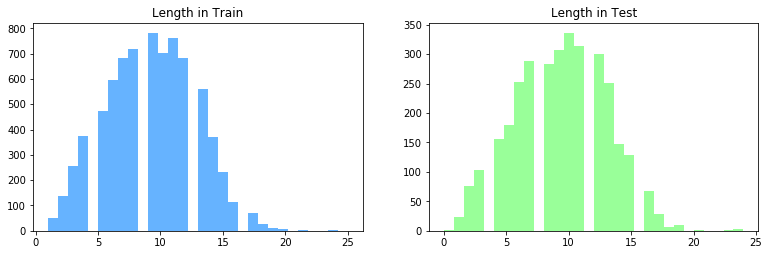

In [0]:
plt.figure(figsize=(13,13))

plt.subplot(321)
tweet_len=train_dataset['text'].str.split().map(lambda x: len(x))
plt.hist(tweet_len, bins=30, color='#66b3ff')
plt.title('Length in Train')

plt.subplot(322)
tweet_len=test_dataset['text'].str.split().map(lambda x: len(x))
plt.hist(tweet_len, bins=30,color='#99ff99')
plt.title('Length in Test')
plt.show()

I will pick 17:

In [0]:
fix_length = 17
TEXT = data.Field(sequential=True, tokenize="spacy", fix_length=fix_length)
LABEL = data.LabelField(dtype=torch.long, sequential=False)

In [0]:
train_data, test_data = data.TabularDataset.splits(
    path="torchtext_data/", train="train.csv", 
    test="val.csv",format="csv", skip_header=True, 
    fields=[('Text', TEXT), ('Label', LABEL)]
)

Creating iterators:

In [0]:
batch_size = 16

train_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, test_data), sort_key=lambda x: len(x.Text),
    batch_size=batch_size,
    device=device)

In [0]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 6090
Number of testing examples: 1523


In [0]:
TEXT.build_vocab(train_data, vectors=GloVe(name='6B', dim=300))
LABEL.build_vocab(train_data)

.vector_cache/glove.6B.zip: 862MB [06:27, 2.22MB/s]                           
100%|█████████▉| 399663/400000 [00:38<00:00, 10771.95it/s]

In [0]:
word_embeddings = TEXT.vocab.vectors
output_size = 2 #two classes
num_layers = 1
hidden_size = 32 #num of units in our NN
embedding_length = 300 #dim of GloVe vector
vocab_size = len(TEXT.vocab)

I tried just one architecture (LSTM with 2D Max Pooling layer), but I want to try others in nearest future:

In [0]:
model = LSTM2DMaxPoolClassifier(batch_size, output_size, hidden_size, vocab_size, embedding_length, num_layers, word_embeddings)

In [0]:
optimizer = optim.Adam(model.parameters(), lr=2e-3, weight_decay=4e-4)
criterion = nn.CrossEntropyLoss()
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.05)

In [0]:
model = model.to(device)
criterion = criterion.to(device)

100%|█████████▉| 399663/400000 [00:50<00:00, 10771.95it/s]

In [0]:
dataiter_dict = {'train': train_iterator, 'val': test_iterator}
dataset_sizes = {'train':len(train_data), 'val':len(test_data)}

In [0]:
model_fit, res = train_and_eval(model, 
                                criterion, 
                                optimizer, 
                                dataiter_dict, 
                                dataset_sizes,
                                batch_size, 
                                scheduler = exp_lr_scheduler, 
                                num_epochs=7)

starting
Epoch 1/7
----------
train total loss: 0.5846 
train sentiment_acc: 0.7468
val total loss: 0.5453 
val sentiment_acc: 0.7965
saving with loss of 0.5452777867010371 improved over previous 200

Epoch 2/7
----------
train total loss: 0.5395 
train sentiment_acc: 0.7979
val total loss: 0.5266 
val sentiment_acc: 0.8175
saving with loss of 0.5265893768458012 improved over previous 0.5452777867010371

Epoch 3/7
----------
train total loss: 0.5200 
train sentiment_acc: 0.8163
val total loss: 0.5360 
val sentiment_acc: 0.8011

Epoch 4/7
----------
train total loss: 0.5117 
train sentiment_acc: 0.8238
val total loss: 0.5328 
val sentiment_acc: 0.8063

Epoch 5/7
----------
train total loss: 0.5032 
train sentiment_acc: 0.8328
val total loss: 0.5327 
val sentiment_acc: 0.8017

Epoch 6/7
----------
train total loss: 0.5010 
train sentiment_acc: 0.8368
val total loss: 0.5330 
val sentiment_acc: 0.7945

Epoch 7/7
----------
train total loss: 0.4930 
train sentiment_acc: 0.8433
val total los

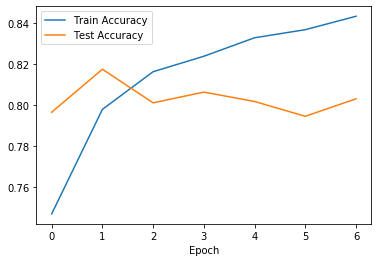

In [0]:
plt.plot(res['train_acc'], label = 'Train Accuracy')
plt.plot(res['val_acc'], label = 'Test Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [0]:
float(res['f1'])

0.760676920413971

Not too bad.

After finding good hyperparameters, I will use Stratified (cause unbalanced set) K-Fold to pick prediction for all training set:

In [0]:
def cross_val(train_dataset, n_folds = 5):

    k_fold = StratifiedKFold(n_splits=n_folds, shuffle=True)
    results = []

    out_of_fold = np.zeros(train_dataset.to_numpy().shape[0])

    for train_index, val_index in k_fold.split(train_dataset, train_dataset['target']):
      
        train_df = train_dataset.iloc[train_index]
        val_df = train_dataset.iloc[val_index]

        train_df.to_csv("torchtext_data/train.csv", index=False)
        val_df.to_csv("torchtext_data/val.csv", index=False)

        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        TEXT = data.Field(sequential=True, tokenize="spacy", fix_length=17)
        LABEL = data.LabelField(dtype=torch.long, sequential=False)

        train_data, val_data = data.TabularDataset.splits(
            path="torchtext_data/", train="train.csv", 
            test="val.csv",format="csv", skip_header=True, 
            fields=[('Text', TEXT), ('Label', LABEL)]
            )
        
        print(f'\nNumber of training examples: {len(train_data)}')
        print(f'Number of testing examples: {len(val_data)}')

        TEXT.build_vocab(train_data, vectors=GloVe(name='6B', dim=300))
        LABEL.build_vocab(train_data)

        batch_size = 16
 
        train_iterator = data.BucketIterator(train_data, 
                                             sort_key=lambda x: len(x.Text),
                                             batch_size=batch_size,
                                             device=device)
        
        val_iterator = data.BucketIterator(val_data,
                                           train=False,
                                           sort = False,
                                           sort_within_batch=False,
                                           repeat=False,
                                           batch_size=batch_size,
                                           device=device)

        model = LSTM2DMaxPoolClassifier(batch_size,
                                        output_size = 2,
                                        hidden_size = 32,
                                        vocab_size = len(TEXT.vocab),
                                        embedding_length = 300,
                                        num_layers = 1,
                                        weights = TEXT.vocab.vectors) 
        
        optimizer = optim.Adam(model.parameters(), lr=2e-3, weight_decay=4e-4)
        criterion = nn.CrossEntropyLoss()
        exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.05)

        model = model.to(device)
        criterion = criterion.to(device)

        val_size = len(val_data)

        train(model, criterion, optimizer, exp_lr_scheduler, train_iterator, batch_size, num_epochs = 7)

        preds = evaluate(model, criterion, optimizer, val_iterator, batch_size, val_size)

        labels = train_dataset['target'].iloc[val_index].to_numpy()
        print('\nF1 for current fold: ', f1_score(labels, preds>0.5))

        out_of_fold[val_index] = preds

        gc.enable()
        del train_df, val_df
        gc.collect()


    print('Overall F1: ', f1_score(train_dataset['target'].to_numpy(), out_of_fold>0.5))
    return out_of_fold

In [0]:
preds = cross_val(train_dataset, 5)


Number of training examples: 6090
Number of testing examples: 1523

F1 for current fold:  0.738799661876585

Number of training examples: 6090
Number of testing examples: 1523

F1 for current fold:  0.7499999999999999

Number of training examples: 6090
Number of testing examples: 1523

F1 for current fold:  0.7738004569687738

Number of training examples: 6091
Number of testing examples: 1522

F1 for current fold:  0.7425343018563357

Number of training examples: 6091
Number of testing examples: 1522

F1 for current fold:  0.7697211155378486
Overall F1:  0.7553293032134902


In [0]:
prediction = pd.DataFrame(preds, columns=['maxpool_lstm'])
prediction.head()

,maxpool_lstm
0,0.000677
1,0.999308
2,0.992427
3,0.998412
4,0.998382


Now, we will use all dataset to train our model:

In [0]:
train_dataset.to_csv("torchtext_data/train.csv", index=False)

In [0]:
train_data = data.TabularDataset(path="torchtext_data/train.csv", 
                                format="csv", 
                                skip_header=True, 
                                fields=[('Text', TEXT), ('Label', LABEL)]
                                )

In [0]:
print(f'Number of testing examples: {len(train_data)}')

Number of testing examples: 7613


Creating new iterator:

In [0]:
batch_size = 16

train_iterator = data.BucketIterator(train_data, 
                                      sort_key=lambda x: len(x.Text),
                                      batch_size=batch_size,
                                      device=device)

In [0]:
model = LSTM2DMaxPoolClassifier(batch_size,
                                output_size = 2,
                                hidden_size = 32,
                                vocab_size = len(TEXT.vocab),
                                embedding_length = 300,
                                num_layers = 1,
                                weights = TEXT.vocab.vectors)

In [0]:
optimizer = optim.Adam(model.parameters(), lr=2e-3, weight_decay=4e-4)
criterion = nn.CrossEntropyLoss()
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.05)

model = model.to(device)
criterion = criterion.to(device)

In [0]:
train(model, criterion, optimizer, exp_lr_scheduler, train_iterator, batch_size, num_epochs = 7)

Done!

And let's make predictions for test dataset:

In [0]:
test_dataset.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [0]:
test_dataset.to_csv("torchtext_data/test.csv", index=False)

In [0]:
test_data = data.TabularDataset(path="torchtext_data/test.csv", 
                                format="csv", 
                                skip_header=True, 
                                fields=[('Text', TEXT)]
                                )

In [0]:
test_size = len(test_data)

In [0]:
print(f'Number of testing examples: {test_size}')

Number of testing examples: 3263


In [0]:
batch_size = 16

# keep in mind the sort_key option 
test_iterator = data.BucketIterator(test_data,
                                    train=False,
                                    sort = False,
                                    sort_within_batch=False,
                                    repeat=False,
                                    batch_size=batch_size,
                                    device=device)

In [0]:
test_preds = test(model, criterion, optimizer, test_iterator, batch_size, test_size)

In [0]:
test_prediction = pd.DataFrame(test_preds, columns=['maxpool_lstm'])

In [0]:
prediction.to_csv('/content/drive/My Drive/tweeter/train_predictions_maxp.csv', index_label='idx')
test_prediction.to_csv('/content/drive/My Drive/tweeter/test_predictions_maxp.csv', index_label='idx')

The threshold of 0.7 get a higher score on the public leaderboard, but our aim is to use prediction as meta-parameters, so it doesn't matter which threshold to choose.

In [0]:
# pred_labels = (preds>0.7).astype(int)

In [0]:
# test_dataset = pd.read_csv('test.csv')
# sub = pd.concat([test_dataset['id'], pd.Series(pred_labels, name='target')], axis=1)

In [0]:
# sub.head()

,id,target
0,0,1
1,2,0
2,3,1
3,9,0
4,11,1


In [0]:
# sub.to_csv('sub.csv', index=False)

In [0]:
# !head sub.csv

id,target
0,1
2,0
3,1
9,0
11,1
12,0
21,0
22,0
27,0


In [0]:
# !kaggle competitions submit -c nlp-getting-started -f sub.csv -m "Message"

100% 22.2k/22.2k [00:03<00:00, 6.64kB/s]
Successfully submitted to Real or Not? NLP with Disaster Tweets